In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [18]:
class f_load_chunk(ParallelMethod):
    def __init__(self, filename, n_workers=1):
        super().__init__()
        self.filename = filename
        with ut.open(filename) as f:
            self.total_events = f['sixBtree'].num_entries
        self.n_workers = n_workers

    def start(self, i):
        step = self.total_events // self.n_workers
        start = i*step
        stop = (i+1)*step

        if i == self.n_workers-1:
            stop = None

        return dict(
            start = start,
            stop = stop,
        )
    
    def run(self, start, stop):
        return dict(
            arrays=ut.open(self.filename)['sixBtree'].arrays(entry_start=start, entry_stop=stop)
            # arrays=(start,stop)
        )
    
    def end(self, i, arrays=None):
        return arrays


In [43]:
from concurrent.futures import ProcessPoolExecutor

def load_chunk(tree, start, stop):
    if tree.closed:
        tree = ut.open(tree.filename)['sixBtree']
    return tree.arrays(entry_start=start, entry_stop=stop)

def load_arrays(tree, num_workers=1, report=False):
    pool = ProcessPoolExecutor(num_workers)
    total_events = tree.num_entries
    step = total_events // num_workers
    workers = [ pool.submit(load_chunk, tree, i*step, (i+1)*step if i+1 < num_workers else None) for i in range(num_workers) ]

    if report: workers = tqdm(workers)
    arrays = [ w.result() for w in workers ]
    return ak.concatenate(arrays)





In [44]:
filename = fc.fs.default.fullpath(fc.eightb.feynnet.v1_20230613.NMSSM_XYY_YToHH_8b_MX_700_MY_300)

with ut.open(filename) as f:
    tree = load_arrays(f['sixBtree'], num_workers=8, report=True)

# import multiprocessing as mp

# with mp.Pool(8) as pool:
#     load_chunk = f_load_chunk(filename, n_workers=pool._processes)
#     arrays = ObjIter(range(pool._processes)).pool_apply(load_chunk, report=True, pool=pool).cat

In [45]:
tree

<Array [{Run: 1, ... ] type='2184287 * {"Run": uint32, "LumiSec": uint32, "Event...'>

In [34]:
load_chunk.total_events

2184287

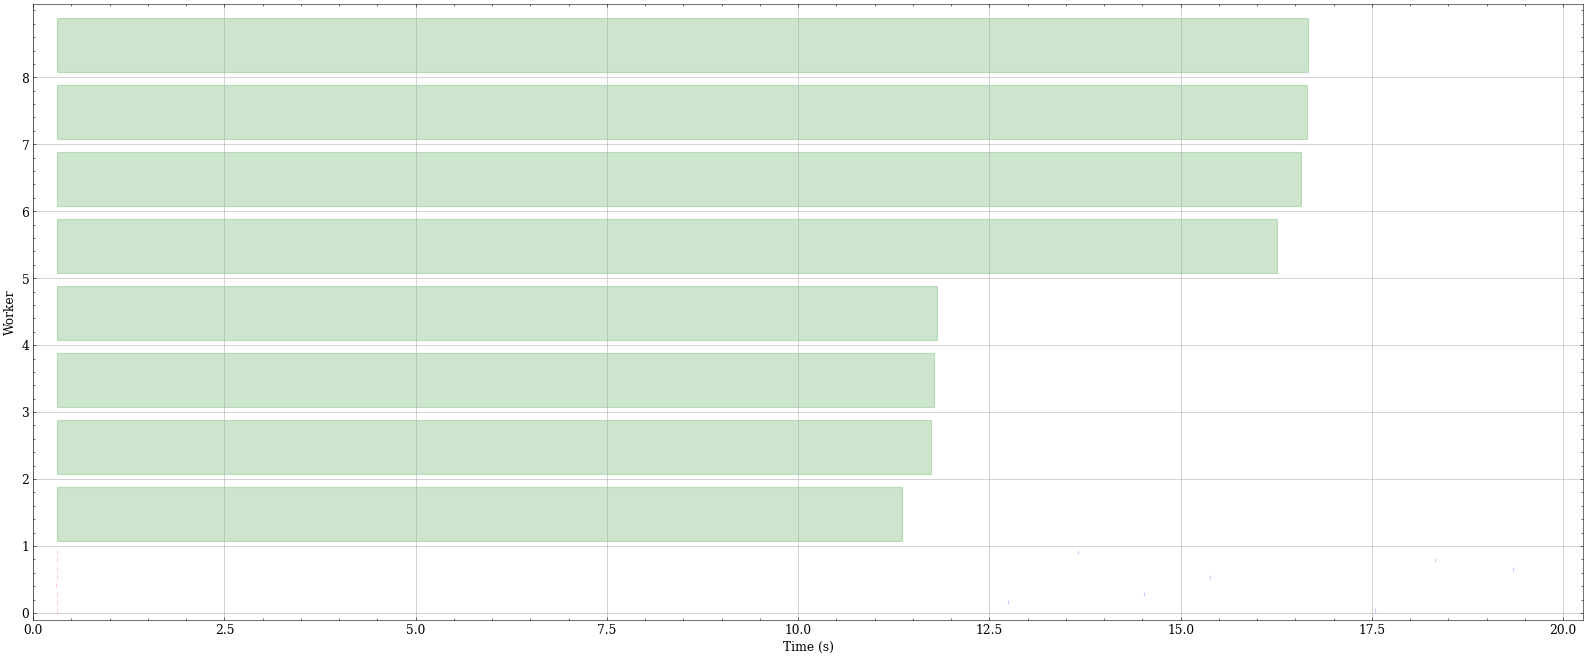

In [35]:
study.plot_timing(load_chunk)

In [36]:
?ut.TTree.arrays

Signature:
ut.TTree.arrays(
    self,
    expressions=None,
    cut=None,
    filter_name=<function no_filter at 0x7efe4c55c280>,
    filter_typename=<function no_filter at 0x7efe4c55c280>,
    filter_branch=<function no_filter at 0x7efe4c55c280>,
    aliases=None,
    language=uproot.language.python.PythonLanguage(),
    entry_start=None,
    entry_stop=None,
    decompression_executor=None,
    interpretation_executor=None,
    array_cache='inherit',
    library='ak',
    how=None,
)
Docstring:
Args:
    expressions (None, str, or list of str): Names of ``TBranches`` or
        aliases to convert to arrays or mathematical expressions of them.
        Uses the ``language`` to evaluate. If None, all ``TBranches``
        selected by the filters are included.
    cut (None or str): If not None, this expression filters all of the
        ``expressions``.
    filter_name (None, glob string, regex string in ``"/pattern/i"`` syntax, function of str → bool, or iterable of the above): A
     